In [7]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import hstack
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
import numpy as np
from scipy.sparse import hstack, csr_matrix
warnings.filterwarnings('ignore')

In [8]:
import pandas as pd

# Load the dataset
file_path = 'tugas_genap.csv'
df = pd.read_csv(file_path)

# Display the first few rows
df.head()


,game_name,meta_score,user_score,platform,description,url,developer,genre,type,rating
0,The Legend of Zelda: Ocarina of Time,99.0,91.0,['nintendo-64'],"As a young boy, Link is tricked by Ganondorf, ...",https://www.metacritic.com/game/nintendo-64/th...,Nintendo,"['Action Adventure', 'Fantasy']",singleplayer,E
1,Super Mario Galaxy,97.0,91.0,['wii'],[Metacritic's 2007 Wii Game of the Year] The u...,https://www.metacritic.com/game/wii/super-mari...,Nintendo,"['Action', 'Platformer', '3D']",singleplayer,E
2,Super Mario Galaxy 2,97.0,91.0,['wii'],"Super Mario Galaxy 2, the sequel to the galaxy...",https://www.metacritic.com/game/wii/super-mari...,Nintendo EAD Tokyo,"['Action', 'Platformer', '3D']",singleplayer,E
3,Metroid Prime,97.0,89.0,['gamecube'],Samus returns in a new mission to unravel the ...,https://www.metacritic.com/game/gamecube/metro...,Retro Studios,"['Action', 'Shooter', 'First-Person', 'Sci-Fi']",singleplayer,T
4,Super Mario Odyssey,97.0,89.0,['switch'],New Evolution of Mario Sandbox-Style Gameplay....,https://www.metacritic.com/game/switch/super-m...,Nintendo,"['Action', 'Platformer', '3D']",singleplayer,E10+


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Informasi dasar
basic_info = df.info()

# Cek missing values
missing_values = df.isnull().sum()

# Statistik deskriptif untuk skor
stats_summary = df[['meta_score', 'user_score']].describe()

# Distribusi genre (jumlah kemunculan genre secara keseluruhan)
from collections import Counter
import ast

# Parsing genre menjadi list
all_genres = df['genre'].dropna().apply(ast.literal_eval)
genre_flat = [g for sublist in all_genres for g in sublist]
genre_counts = Counter(genre_flat)
top_genres = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

basic_info, missing_values, stats_summary, top_genres.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   game_name    2000 non-null   object 
 1   meta_score   2000 non-null   float64
 2   user_score   2000 non-null   float64
 3   platform     2000 non-null   object 
 4   description  1980 non-null   object 
 5   url          2000 non-null   object 
 6   developer    1998 non-null   object 
 7   genre        1999 non-null   object 
 8   type         1571 non-null   object 
 9   rating       1696 non-null   object 
dtypes: float64(2), object(8)
memory usage: 156.4+ KB


(None,
 game_name        0
 meta_score       0
 user_score       0
 platform         0
 description     20
 url              0
 developer        2
 genre            1
 type           429
 rating         304
 dtype: int64,
         meta_score   user_score
 count  2000.000000  2000.000000
 mean     80.854000    76.765000
 std       5.179392    10.225804
 min      74.000000    12.000000
 25%      77.000000    73.000000
 50%      80.000000    78.000000
 75%      83.000000    84.000000
 max      99.000000    92.000000,
                Genre  Count
 2             Action    662
 27           General    530
 22      Role-Playing    289
 33          Strategy    289
 5            Shooter    219
 20     Miscellaneous    217
 0   Action Adventure    217
 3         Platformer    192
 37                2D    187
 8          Adventure    177)

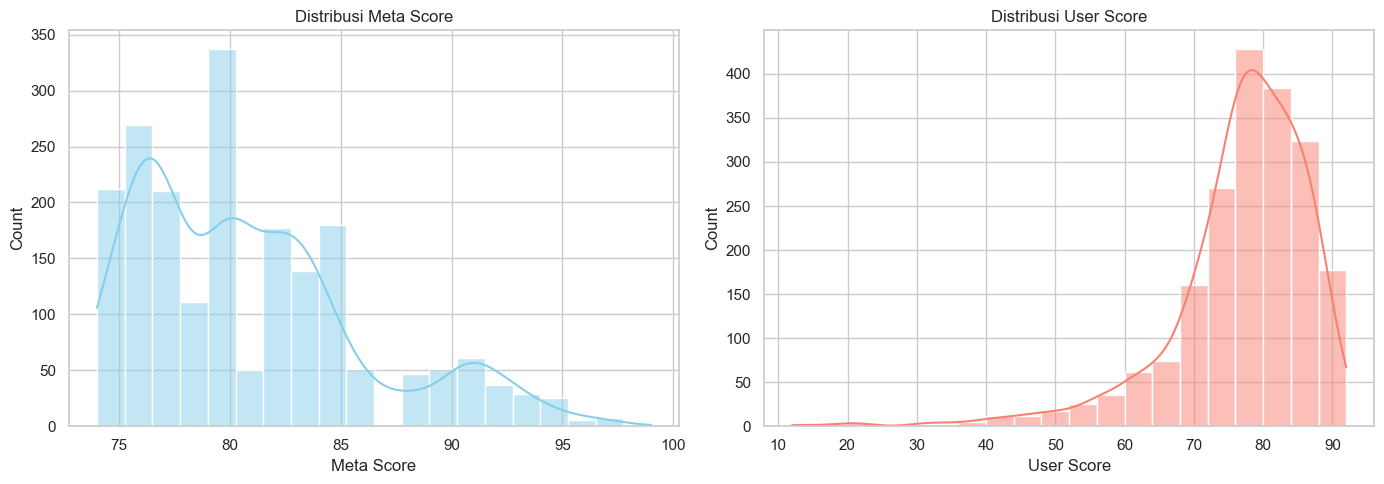

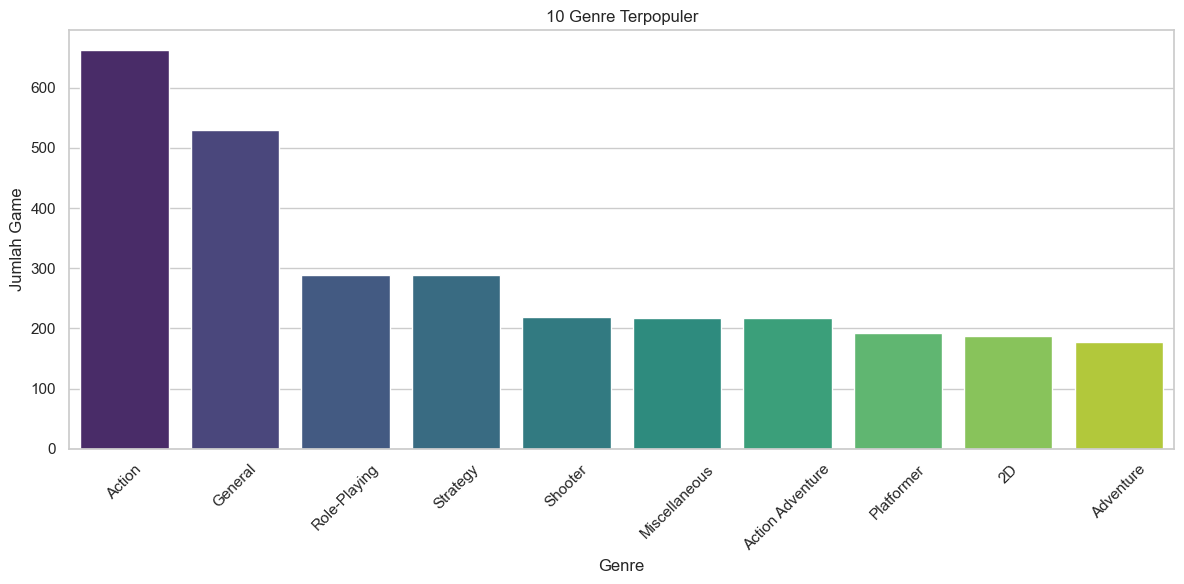

In [10]:
# Set style
sns.set(style="whitegrid")

# Plot distribusi meta_score dan user_score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df['meta_score'], bins=20, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Distribusi Meta Score")
axes[0].set_xlabel("Meta Score")

sns.histplot(df['user_score'], bins=20, kde=True, ax=axes[1], color='salmon')
axes[1].set_title("Distribusi User Score")
axes[1].set_xlabel("User Score")

plt.tight_layout()
plt.show()

# Plot genre terpopuler
plt.figure(figsize=(12, 6))
sns.barplot(data=top_genres.head(10), x='Genre', y='Count', palette='viridis')
plt.title("10 Genre Terpopuler")
plt.xticks(rotation=45)
plt.xlabel("Genre")
plt.ylabel("Jumlah Game")
plt.tight_layout()
plt.show()


# Data Preprocessing

In [11]:
# Drop rows with missing 'genre' or 'description'
df_clean = df.dropna(subset=['genre', 'description']).reset_index(drop=True)

# Convert 'genre' from string list to space-separated string
df_clean['genre_clean'] = df_clean['genre'].apply(lambda x: ' '.join(ast.literal_eval(x)))

# Combine genre and description for text features
df_clean['text_features'] = df_clean['genre_clean'] + ' ' + df_clean['description']

# Feature Extraction

In [12]:
# TF-IDF vectorization on text features
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_text = tfidf.fit_transform(df_clean['text_features'])

# Normalize numerical features
scaler = MinMaxScaler()
X_num = scaler.fit_transform(df_clean[['meta_score', 'user_score']])

# Combine text and numeric features
X_combined = csr_matrix(hstack([X_text, X_num]))

# Train Nearest Neighbors Model

In [13]:
# Initialize and fit Nearest Neighbors model with Euclidean distance
model = NearestNeighbors(metric='euclidean')
model.fit(X_combined)

NearestNeighbors(metric='euclidean')

# Make Recommendations

In [17]:
# Select a game title to find similar games
selected_game = "Persona 5 Royal"
idx = df_clean[df_clean['game_name'].str.lower() == selected_game.lower()].index[0]

# Get top 6 neighbors (including the input itself)
distances, indices = model.kneighbors(X_combined[idx], n_neighbors=6)

# Prepare recommendations excluding the first (itself)
recommendations = df_clean.iloc[indices[0][1:]][['game_name', 'meta_score', 'user_score', 'genre']].reset_index(drop=True)

# Display recommendations
recommendations

,game_name,meta_score,user_score,genre
0,Persona 4 Golden,93.0,86.0,"['Role-Playing', 'Console-style RPG', 'Japanes..."
1,Persona 5,93.0,87.0,"['Role-Playing', 'Japanese-Style']"
2,Persona 4 Arena Ultimax,85.0,43.0,"['Action', 'Fighting', '2D']"
3,Persona 2: Eternal Punishment,83.0,45.0,"['Role-Playing', 'Console-style RPG']"
4,Mass Effect,91.0,87.0,"['Role-Playing', 'Action RPG', 'Console-style ..."


In [ ]:


# Drop rows with missing 'genre' or 'description'
df_clean = df.dropna(subset=['genre', 'description'])

# Reset index for consistent indexing
df_clean = df_clean.reset_index(drop=True)

# Preprocessing genre: convert from string to space-separated string of genres
df_clean['genre_clean'] = df_clean['genre'].apply(lambda x: ' '.join(ast.literal_eval(x)))

# Combine 'genre' and 'description' for text features
df_clean['text_features'] = df_clean['genre_clean'] + ' ' + df_clean['description']

# TF-IDF vectorizer for combined text
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)

# Normalize numerical features
scaler = MinMaxScaler()
numerical_features = df_clean[['meta_score', 'user_score']]

# Apply TF-IDF and scaling
X_text = tfidf.fit_transform(df_clean['text_features'])
X_num = scaler.fit_transform(numerical_features)

# Combine both feature sets
X_combined = csr_matrix(hstack([X_text, X_num]))

# Fit Nearest Neighbors model with Euclidean Distance
model = NearestNeighbors(metric='euclidean', algorithm='auto')
model.fit(X_combined)

# Find index of the selected game
selected_game = "Super Mario Odyssey"
idx = df_clean[df_clean['game_name'].str.lower() == selected_game.lower()].index[0]

# Get recommendations (top 6 including input)
distances, indices = model.kneighbors(X_combined[idx], n_neighbors=6)

# Prepare result excluding the first (itself)
recommendations = df_clean.iloc[indices[0][1:]][['game_name', 'meta_score', 'user_score', 'genre']].copy()
recommendations.reset_index(drop=True, inplace=True)
recommendations


,game_name,meta_score,user_score,genre
0,Super Mario World: Super Mario Advance 2,92.0,90.0,"['Action', 'Platformer', '2D']"
1,Super Mario Advance 4: Super Mario Bros. 3,94.0,89.0,"['Action', 'Platformer', '2D']"
2,Super Mario 3D World,93.0,89.0,"['Platformer', '3D', 'Action']"
3,Super Mario Sunshine,92.0,84.0,"['Action', 'Platformer', '3D']"
4,Paper Mario,93.0,90.0,"['Role-Playing', 'Console-style RPG']"
